Niko Itänen <br>
Student number: 2110412 <br>
January, 29, 2025  <br>

# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2025

##### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it. Please, add your full name to the file name.
    - The exercise will be graded by a maximum of 2 points.
    - Submit to moodle your solution on ** Wednesday 5 of February ** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br> 
Submissions with identical or similar code will result in a failure for the exercise.</b>

## Import libraries

In [201]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from scipy.stats import somersd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p> 

In the following cell: 
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [202]:
# Read the data
water = pd.read_csv("data/water_data.csv")

# Print the dimensions
print("Dimensions:", water.shape[1])

# Print the first 5 rows
print(water.head())

# Define the input features and the target feature
# c_total = total concentration of metals
# Cd = cadmium concentration
# Pb = lead concentration
input_features = ['Mod1', 'Mod2', 'Mod3'] # Mod1, Mod2, Mod3 are the features we will use as input for the model

target_feature = ['c_total', 'Cd', 'Pb'] # c_total, Cd, Pd are the target features we will predict

# Create a new dataframe for the input features and target feature
inputDf = water[input_features]
targetDf = water[target_feature]

Dimensions: 6
   c_total   Cd    Pb      Mod1      Mod2      Mod3
0      0.0  0.0   0.0 -0.999216 -0.714208 -0.414911
1      0.0  0.0   0.0 -0.990800 -0.714373 -0.238335
2      0.0  0.0   0.0 -0.990539 -0.714125  0.020788
3     14.0  0.0  14.0 -1.001247 -0.713546  0.945465
4     14.0  0.0  14.0 -1.013727 -0.714125  0.569631


Now we have read the data, printed the data dimensions and the first five rows. We have also defined both the input features and the target features as their own dataframes.

We now move on to defining the number of mixtures.

In [203]:
# At first we want to calculate the count of mixtures for each row of input features
water['mixture_id'] = water[target_feature].apply(lambda x: ''.join(x.astype(str)), axis=1) # New column that contains the mixture id as string (in form of "c_totalCdPb")
mixture_count = water['mixture_id'].value_counts() # Count the number of how many times each replica appears

# Now we want to calculate the count of how many time each mixture have exactly the same 3 and 4 replicas.
sum_of_3_replicas = (mixture_count == 3).sum()
sum_of_4_replicas = (mixture_count == 4).sum()

# Print the results
print("The number of mixtures that have exactly 3 replicas:", sum_of_3_replicas)
print("The number of mixtures that have exactly 4 replicas:", sum_of_4_replicas)

The number of mixtures that have exactly 3 replicas: 43
The number of mixtures that have exactly 4 replicas: 24


As we can see, there are a total of 43 mixtures with 3 replicas and 24 mixtures with 4 replicas. The purpose of these replications is to increase robustness, avoid overfitting the model and validate the predictions in a realistic way [1].

## C-index code 

In [204]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## Functions

In [205]:
# Lets create a k-nn regression here
# X_train: our input features of the training set
# Y_train: target feature of the training set
# X_test: input features of the test set
# k: number of neighbors

def knn_regression(X_train, Y_train, X_test, k=3):
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean') # We want to use the euclidean distance as the metric
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    Y_pred = pd.DataFrame(Y_pred, columns=Y_train.columns)
    return Y_pred


# Here we implement the leave-one-out cross-validation function
# X: input data
# Y: target data
# target_feature: the target feature we want to predict
# k_values: list of k values to try multiple k values
def leave_one_out_cv(X, Y, target_feature, k_values=[1, 3, 5, 7]):
    Y = pd.DataFrame(Y, columns=[target_feature])
    # Define leave-one-out cross-validation
    loo = LeaveOneOut()
    c_values = []

    for k in k_values:
        test_list = [] # List to store the true target feature values after each iteration
        pred_list = [] # Same for the predicted target feature values

        # Iterate the training and test sets for each fold
        for train_index, test_index in loo.split(X):
            # Here we want to split the data into training and test sets
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            # Now apply the earlier made knn_regression function
            Y_pred = knn_regression(X_train, Y_train, X_test, k)

            # Append the true and predicted target feature values to the lists.
            test_list.append(Y_test.values[0][0])
            pred_list.append(Y_pred.values[0][0])

        # Calculate the C-index value with function created earlier
        c_index_value = cindex(test_list, pred_list)
        # Append the C-index value to the list
        c_values.append(c_index_value)

    return c_values

# Here we implement the leave-replicas-out cross-validation function
def leave_replicas_out_cv2(X, Y, target_feature, k_values=[1, 3, 5, 7]):
    # Find all replicas from the data
    unique_replicas = water['mixture_id'].unique()
    # Define the amount of splits, one for each unique replica
    kf = KFold(n_splits=len(unique_replicas))
    c_values = []

    for k in k_values:
        # Create lists again to store the true and predicted target feature values
        test_list = []
        pred_list = []

        for train_index, test_index in kf.split(unique_replicas):
        # Iterate the training and test set for each fold
            # We want to define training and test index by using the unique replica ids
            train_index = water[water['mixture_id'].isin(unique_replicas[train_index])].index
            test_index = water[water['mixture_id'].isin(unique_replicas[test_index])].index

            # Split the data into training and test sets
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            Y_train, Y_test = Y.loc[train_index], Y.loc[test_index]

            # Now apply the knn_regression function
            Y_pred = knn_regression(X_train, Y_train, X_test, k)

            # Append the true and predicted target feature values to the lists
            test_list.append(Y_test.values[0][0])
            pred_list.append(Y_pred.values[0][0])

        # Calculate the C-index value
        c_index_value = cindex(test_list, pred_list)
        # Append these calculated values to the list
        c_values.append(c_index_value)
    return c_values

## Results for Leave-One-Out cross-validation

In [206]:
# Here run your script for Leave-One-Out cross-validation and print the corresponding results.

# Here we create a dictionary to store the results
results_LOOCV = {}

# Run the LOOCV for each target features
for target in target_feature:
    LOOCV_scores = leave_one_out_cv(inputDf, targetDf, target_feature=target)
    # Save the computed result to the dictionary
    results_LOOCV[target] = LOOCV_scores

# Let's print the results
for target in target_feature:
    print("Calculated target feature:", target)
    print("LOOCV scores:", results_LOOCV[target], "\n")

Calculated target feature: c_total
LOOCV scores: [0.9082833811137173, 0.9141907740422205, 0.8941012944140387, 0.8737294761532447] 

Calculated target feature: Cd
LOOCV scores: [0.921869127656909, 0.8995907629348143, 0.8619660082682591, 0.8141520858562659] 

Calculated target feature: Pb
LOOCV scores: [0.8805487117384223, 0.8744519146448406, 0.8542614941328768, 0.8355326345680043] 



## Results for Leave-Replicas-Out cross-validation

In [207]:
# Run Leave-Replicas-Out cross-validation for each target feature
# Dictionary for result storing
results_LROCV = {}

# Run the LROCV for each target feature
for target in target_feature:
    LROCV_scores = leave_replicas_out_cv2(inputDf, targetDf, target_feature=[target])
    # Save the result to the dictionary
    results_LROCV[target] = LROCV_scores

# Print the results
for target in target_feature:
    print("Calculated target feature:", target)
    print("LOOCV scores:", results_LROCV[target], "\n")

Calculated target feature: c_total
LOOCV scores: [0.8250244379276637, 0.8338220918866079, 0.8242913000977516, 0.8225806451612903] 

Calculated target feature: Cd
LOOCV scores: [0.8250244379276637, 0.8338220918866079, 0.8242913000977516, 0.8225806451612903] 

Calculated target feature: Pb
LOOCV scores: [0.8250244379276637, 0.8338220918866079, 0.8242913000977516, 0.8225806451612903] 



## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

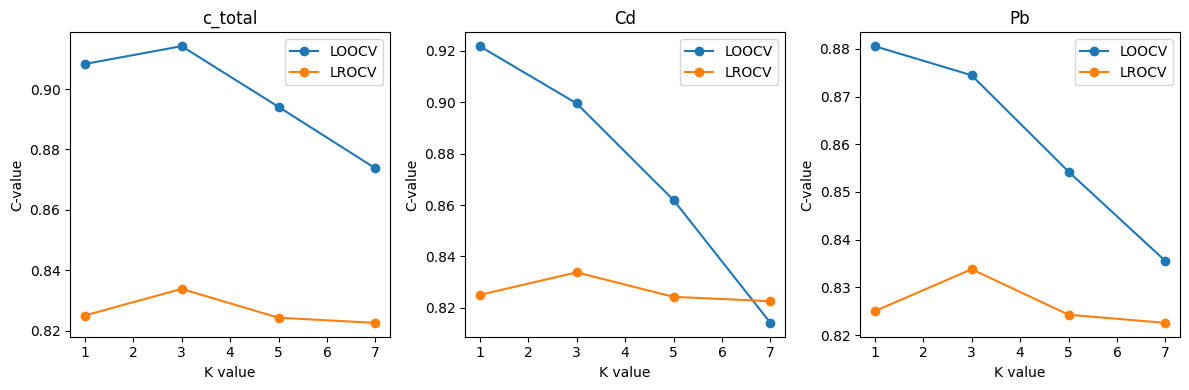

In [ ]:
# Let's visualize the results we have calculated
plt.figure(figsize=(12, 4))
# Loop each target feature for one subplot
for i, target in enumerate(target_feature):
    plt.subplot(1, 3, i+1)
    
    # Plot the Leave-One-Out cross-validation results
    plt.plot([1, 3, 5, 7], results_LOOCV[target], label='LOOCV', marker='o')

    # Plot the Leave-Replicas-Out cross-validation results
    plt.plot([1, 3, 5, 7], results_LROCV[target], label='LROCV', marker='o')

    # Add labels and title
    plt.xlabel('K value')
    plt.ylabel('C-value')
    plt.title(target_feature[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:

1. We obtained more optimistic results with Leave-One-Out Cross-Validation (LOOCV) than with Leave-Replicas-Out Cross-Validation (LROCV). The C-values for LOOCV were somewhere near 0.9, which decreases quite rapidly as the K-value increases. In contrast, the C-value of LROCV was much more stable and remained consistently close to 0.8. Although LOOCV has a better C-value, this does not mean that it is more accurate than LROCV in real-world case and with unseen data.

2. Although LOOCV has a higher value, it is likely overfitting because there are still replicates in the training set. The model predicts these values well but is unlikely to perform as well with unseen data. Although the C-value of LROCV is lower, its accuracy may actually be higher because it is not as biased as LOOCV, since all replicates are observed here during training of the data. If these replicas are processed, it does not learn these replicas and gets more accuracy with the unseen data.

# References:

[1] https://doc.perclass.com/perClass_Mira/Cross-validationoverreplicas.html